# Tensorflow Similarity Advanced colab

Before using this colab -- please refers to[]

## Notebook goal
We are going to demonstrate:
1. Random sampling from disk using TFRecordDatasetSampler.
2. Training using an existing Keras base model.

## References
- Start here

Send feeback to elieb@  - code: [private github (ask for access)](https://github.com/tensorflow/similarity)

# colab emphase
- metrics
- callbacks
- custom threshold
- tf.dataset usage

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Required to load the stanford_dogs dataset
# This will install scipy in your current pyenv.
import sys
!{sys.executable} -m pip install scipy;

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
import collections
import re
from time import time
from pathlib import Path

from IPython.display import display, Markdown
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import applications
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_datasets as tfds
from tabulate import tabulate
from tqdm.auto import tqdm

In [4]:
import tensorflow_similarity as tfsim
from tensorflow_similarity.callbacks import EvalCallback  # evaluate matching performance
from tensorflow_similarity.callbacks import SplitValidationLoss # evaluate validation loss on known and unknown classes
from tensorflow_similarity.distance_metrics import avg_neg, avg_pos, dist_gap, max_pos, min_neg  # various metrics on how the distance between examples evolve.
from tensorflow_similarity.losses import MultiSimilarityLoss  # specialized loss
from tensorflow_similarity.metrics import batch_class_ratio
from tensorflow_similarity.models import SimilarityModel # TF model with additional features
from tensorflow_similarity.samplers import select_examples  # select n example per class
from tensorflow_similarity.samplers import TFRecordDatasetSampler
from tensorflow_similarity.utils import tf_cap_memory
from tensorflow_similarity.visualization import confusion_matrix  # matching performance
from tensorflow_similarity.visualization import viz_neigbors_imgs  # Neigboors vizualisation

In [5]:
# make sure TF don't blew up
tf_cap_memory()
print('TensorFlow:', tf.__version__)
print('TensorFlow_datasets:', tfds.__version__)
print('TensorFlow Similarity', tfsim.__version__)
_gpu = tf.config.list_physical_devices('GPU')
print(f'GPU is {_gpu if len(_gpu) else "NOT AVAILABLE"}')

TensorFlow: 2.4.1
TensorFlow_datasets: 4.3.0
TensorFlow Similarity 0.13.7
GPU is [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data preparation

We are going to load the [Stanford Dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs) dataset and restrict our training data to only N of the 120 classes (60 by default). This showcases how the model is able to find similar examples from classes unseen during training, and is one of the main reason you would want to use metric learning.


**Important**: Tensorflow similarity expects the `y_train` examples class as integers. Accordingly, we are leavig `y_train` as is instead of applying the standard categorical encoding.

In [6]:
stanford_dogs_builder = tfds.builder(name='stanford_dogs')
stanford_dogs_builder.download_and_prepare()
data_path = stanford_dogs_builder.data_path
print(f'Data Path: {data_path}')

Data Path: /home/jupyter/tensorflow_datasets/stanford_dogs/0.2.0


In [7]:
# We are only interested in the 'image' and 'label' fields.
stanford_dogs_builder.info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [8]:
IMG_SIZE = 320
MDL_IMG_SIZE = 224
CHANNELS=3
INPUT_SHAPE=(IMG_SIZE, IMG_SIZE, CHANNELS)
NUM_CLASSES = 120
NUM_KNOWN_CLASSES = 60  #@param {type: "slider", min: 1, max: 120}
BATCH_SIZE = 128

classes = np.random.choice(NUM_CLASSES, size=NUM_KNOWN_CLASSES, replace=False)
# note we added 'unknown' as the 121st class
labels = [f"{i}" for i in range(NUM_CLASSES)] + ["Unknown"]


def img_decoder(image):
    image = tf.image.decode_image(image, channels=CHANNELS)
    image = tf.image.resize_with_crop_or_pad(
        image, 
        target_height=IMG_SIZE, 
        target_width=IMG_SIZE
    )
    return image

# We need to wrap the img_decoder before passing it to the dataset builder.
@tfds.decode.make_decoder(output_dtype=tf.float32)
def decode_wraper(image, _):
    return img_decoder(image)


x_test, y_test = stanford_dogs_builder.as_dataset(
    split='test', 
    shuffle_files=True, 
    as_supervised=True,
    batch_size=-1,
    decoders={'image': decode_wraper()},
)

# Sort Train Data by Class
To learn efficiently each batch must contains at least 2 sample of each class. Additionally it is often useful to have multiple examples of each class so we can mine informative triplet using different mining strategies (e.g *semi-hard* mining).

To make this easy, tf_similarity offers `Samplers()` that control the total number of classes and the minum number of examples of each class. Here we are using `TFRecordDatasetSampler()` which allows us to sample a large dataset by sampling over tfrecords. 

We expect the examples to be in contiguous blocks in the records. The simplest way to do this is to write a record for each class.

In [9]:
# Here we:
#   * Read the raw data and add it to a dict keyed by class.
#   * Serialize the raw image byte string and the label int.
#   * Materialize a tfrecord for each key in the dict.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        # BytesList won't unpack a string from an EagerTensor.
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def to_tfrecord(img, label):
    feature = {
      'image': _bytes_feature(img),
      'label': _int64_feature(label),
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()


def to_sharded_tfrecord(ds, dspath, classes, classes_per_shard=10):
    shards = collections.defaultdict(list)

    # delete existing shards:
    for shard in Path(dspath).glob("stanford_dogs-train-sorted_*.tfrecord"):
        if shard.exists():
            shard.unlink()
            
    # assign examples to the right shard
    for example in tqdm(ds, unit='examples'):
        lbl = int(example['label'])
        if lbl in classes:
            sid = int(lbl / classes_per_shard  + 10)
            shards[sid].append(example)
            
    pbar = tqdm(shards.items(), unit='shards')
    sids = []
    for sid, data in pbar:
        shard_path = Path(dspath) / f"stanford_dogs-train-sorted_{sid}.tfrecord"
        sids.append(sid)
        pbar.set_postfix({'sids': sids})
        with tf.io.TFRecordWriter(str(shard_path)) as writer:
            for fd in data:
                example = to_tfrecord(fd['image'], int(fd['label']))
                writer.write(example)

raw_train_data = stanford_dogs_builder.as_dataset(
    split='train', 
    shuffle_files=True,   
    decoders={'image': tfds.decode.SkipDecoding()}
)

to_sharded_tfrecord(raw_train_data, data_path, classes)

  0%|          | 0/12000 [00:00<?, ?examples/s]

  0%|          | 0/12 [00:00<?, ?shards/s]

In [10]:
def deserialization_fn(tf_example):
    fd = {
        'image': tf.io.FixedLenFeature([], dtype=tf.string),
        'label': tf.io.FixedLenFeature([], dtype=tf.int64),
    }
    sample = tf.io.parse_single_example(tf_example, fd)
    image = img_decoder(sample['image']) 
    label = sample['label']
    
    return (image, label)

# Overall the way we make the sampling process is by using
# tf.dataset.interleaves in a non orthodox way 
# (see: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#interleave).
# We use `block_length` to control the number of examples per class and rely on
# the parallelize & non_deterministic version of the API to do the sampling 
# efficiently for us.

sampler = TFRecordDatasetSampler(
    data_path, 
    deserialization_fn=deserialization_fn,
    batch_size=BATCH_SIZE,
    file_parallelism=12,
    prefetch_size=20,
    shard_suffix="*.tfrecord")

found 12 shards


In [11]:
# Verify that we have at least 2 examples per class within each batch.
bcr = batch_class_ratio(sampler, num_batches=100)
print(f'{bcr:.2f} examples per class on average.')

2.87 examples per class on average.


## Data augmentation

In [12]:
# Create an image augmentation pipeline.
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.15),
    layers.experimental.preprocessing.RandomCrop(224, 224),
])

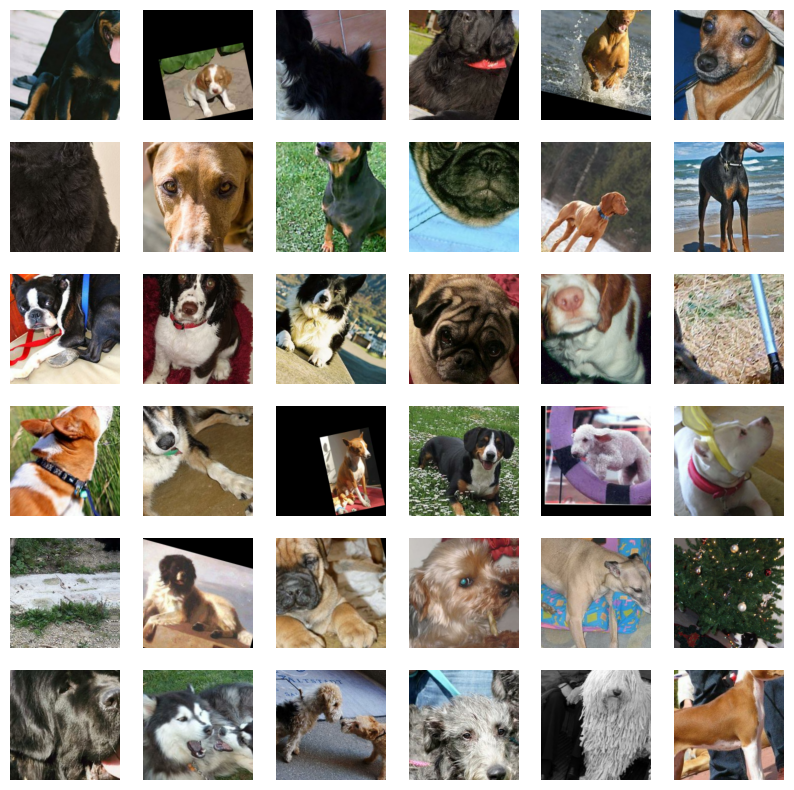

In [13]:
# Examples of the augmented images.
num_imgs = 6
si = iter(sampler)
examples = [next(si)[0] for _ in range(num_imgs**2)]
plt.figure(figsize=(10, 10))
for i in range(num_imgs**2):
    ax = plt.subplot(num_imgs, num_imgs, i + 1)
    augmented_image = data_augmentation(examples[i])
    plt.imshow(augmented_image[0] / 255)
    plt.axis("off")

## Model definition
Triplet loss models are normal `tensorflow.keras` models except their output is a distance embeding. We use `SimilarityModel()` instead of the default `Model()` because this subclass contains additional proprerty that makes indexing and searching embeddings easy once the training is done.

Here we use Efficient Net B0 as our base model ([paper](https://arxiv.org/pdf/1905.11946.pdf)). This demonstrates how a `SimilarityModel()` can easily extend existing Keras model.

In [14]:
# Build the model using the frozen EfficientNetB0 model.
# The EfficientNetB0 expects the images to be (255, 255, 3)
# Additionally, EfficientNetB0 will scale the images to [0,1) within the model.
def base_model(x):
    preprocess_input = tf.keras.applications.efficientnet.preprocess_input
    enet = applications.EfficientNetB0(
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze all the layers before the the last 2 blocks
    # and don't train the batch norm layers!
    enet.trainable = True
    for layer in enet.layers:
        if not re.search("^block[5,6,7]|^top", layer.name) or isinstance(layer, layers.BatchNormalization):
            layer.trainable =  False
            
    x = preprocess_input(x)
    return enet(x)

def get_model():
    KERNEL_INITIALIZER = {
        'class_name': 'VarianceScaling',
        'config': {
            'scale': 1/3,
            'mode': 'fan_out',
            'distribution': 'uniform'
        }
    }

    x = inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
    x = data_augmentation(x)
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='swish', kernel_initializer=KERNEL_INITIALIZER)(x)
    outputs = layers.Dense(64)(x)
    return SimilarityModel(inputs, outputs)


model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
Total params: 4,221,795
Trainable params: 3,837,288
Non-trainable params: 384,507
__________________________________

## Loss definition

Overall Similarity losses (aka metric losses) are similar to other losses except they expect different inputs.

For multi-similarity loss there is no need to decide what type of triplet mining you want. The loss takes a weighted combination of all valid positive and negative pairs.

The `distance` parameters specify which distance metric to use to compute the distance between embeddings. `cosine` is usually a great starting point and the default.


In [15]:
distance = 'cosine' #@param ["cosine"]{allow-input: false}
ms_loss = MultiSimilarityLoss(distance=distance)

## Evaluation callback
TensorFlow Similarity provides callbacks that makes it easy to evaluate the performance during training. This callback works by taking as input as set of `targets`/`target_labels` which are examples you want to match against and a set of `queries` / `query_labels` that what you want to matches.

Here we are going to use part of the test dataset as targets and another part as queries. 

Notes:

- callback only runs at epoch_end to avoid slowing down the training.
- writing to TF metrics is currently broken pending changes in TensorFlow.
- Logging to TensorBoard works - just add a `tf_logdir` path as illustrated below.


In [16]:
num_targets = 200 #@param {type:"int"}
num_queries = 300 #@param {type:"int"}
k = 3 #@param {type:"int"}
log_dir = 'logs/%d/' % (time())
query_offset = num_targets + num_queries
# TFsim callback for match rate
tsc = EvalCallback(
    x_test[:num_targets], 
    y_test[:num_targets], 
    x_test[num_targets:query_offset], 
    y_test[num_targets:query_offset], 
    k=k, 
    tb_logdir=log_dir
)
  
# Tensorboard callback
tbc = TensorBoard(log_dir=log_dir)

# SplitValidation callback
val_loss = SplitValidationLoss(
    x=x_test[: 5_000], 
    y=y_test[: 5_000], 
    known_classes=np.array(classes),
)

TensorBoard logging enable in logs/1629244819/index


In [17]:
LR = 0.0001  #@param {type:"float"}
steps = 1
model = get_model()
model.compile(optimizer=Adam(LR), loss=ms_loss, steps_per_execution=steps)

Distance metric automatically set to cosine use the distance arg to override.


In [18]:
EPOCHS = 15 #@param {type:"integer"}
STEPS_PER_EPOCH = 1000 #@param {type:"integer"}
history = model.fit(
    sampler, 
    epochs=EPOCHS, 
    steps_per_epoch=STEPS_PER_EPOCH, 
    validation_data=(x_test,y_test),
    callbacks=[val_loss, tbc, tsc]
)

Epoch 1/15
   6/1000 [..............................] - ETA: 6:02 - loss: 1.7036WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0956s vs `on_train_batch_end` time: 0.1494s). Check your callbacks.


1000/1000 [==============================] - 167s 149ms/step - loss: 1.4521 - val_loss: 0.2643
val_los - known_classes: 0.4119 - unknown_classes: 0.4902
accuracy:0.1550 - mean_rank:2.9308
Epoch 2/15
1000/1000 [==============================] - 145s 145ms/step - loss: 1.3273 - val_loss: 0.2573
val_los - known_classes: 0.3510 - unknown_classes: 0.4980
accuracy:0.1250 - mean_rank:3.0000
Epoch 3/15
1000/1000 [==============================] - 144s 144ms/step - loss: 1.1262 - val_loss: 0.2540
val_los - known_classes: 0.3434 - unknown_classes: 0.4896
accuracy:0.1300 - mean_rank:3.0395
Epoch 4/15
1000/1000 [==============================] - 144s 144ms/step - loss: 0.8918 - val_loss: 0.2483
val_los - known_classes: 0.3240 - unknown_classes: 0.4903
accuracy:0.1150 - mean_rank:3.1458
Epoch 5/15
1000/1000 [==============================] - 144s 144ms/step - loss: 0.6971 - val_loss: 0.2531
val_los - known_classes: 0.3307 - unknown_classes: 0.4960
accuracy:0.1250 - mean_rank:3.1690
Epoch 6/15
1000/

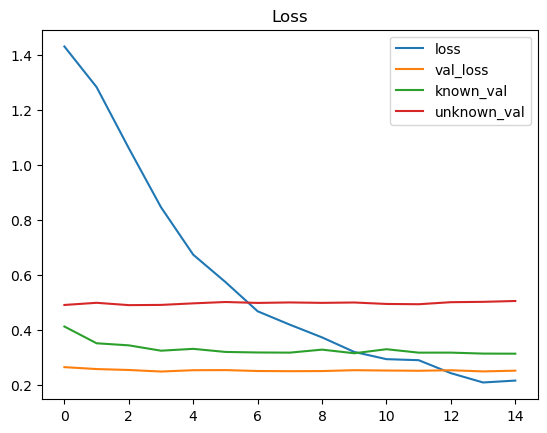

In [19]:
# expect loss: 0.05 / val_loss: 0.8
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['known_val_loss'])
plt.plot(history.history['unknown_val_loss'])
plt.legend(['loss', 'val_loss', 'known_val', 'unknown_val'])
plt.title('Loss')
plt.show()

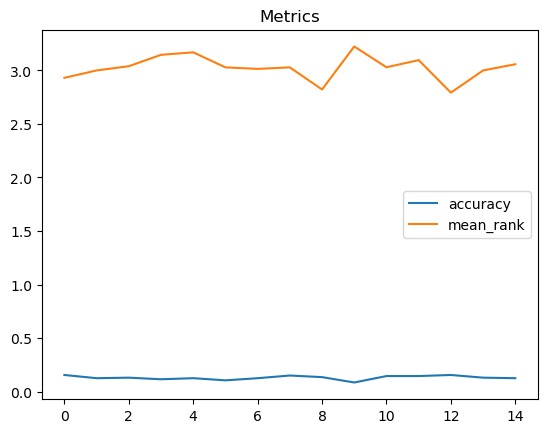

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['mean_rank'])
plt.legend(['accuracy', 'mean_rank'])
plt.title('Metrics')
plt.show()

# Indexing

Indexing is where things get different from traditional classification models. Because the model learned to output an embedding that represent the example position in a metric space and not a classification, we need a way to find which known example(s) are the closest to determine the class of the incoming data (aka nearest neighboors classication).

To do so we need to **create an index of known example from the 10 cloth classes**. We do this by taking **200 examples from the train dataset which amount to 20 examples** for each class and use the `index()` funtion of the model to build the index.

Adding more examples per class, helps increase the accuracy/generalization as you improve the set of known variations that the classifier "knows". 

Reseting the index is not necessary but it ensure we start with a clean index in case of a re-run

In [21]:
# Convert the dataset to X and y collections.
# TODO(ovallis) Provide an approach that works for large datasets  => probaby not needed.
x_train, y_train = zip(*stanford_dogs_builder.as_dataset(
    split='train', 
    as_supervised=True,
    decoders={'image': decode_wraper()}
))

In [22]:
x_index, y_index = select_examples(x_train, y_train, range(120), 20)
model.reset_index()
model.index(x_index, y_index, data=x_index)

filtering examples:   0%|          | 0/12000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/120 [00:00<?, ?it/s]

[Indexing 2400 points]
|-Computing embeddings
|-Storing data points in index table
|-Adding embeddings to index.
|-Building index.


# Querying

To "classify" our testing data, we need for each testing example to look for its *k* [nearest neighbors](https://scikit-learn.org/stable/modules/neighbors.html) in the index.

We query a single random example for each class from the test dataset using  `select_examples()` and then find their nearest neighboors using the `single_lookup()` function.

filtering examples:   0%|          | 0/8580 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/20 [00:00<?, ?it/s]

**Unknown Class**

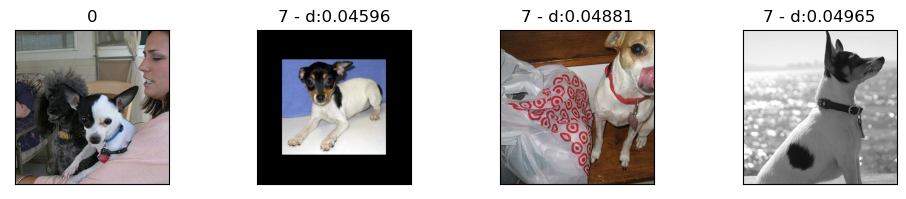

**Unknown Class**

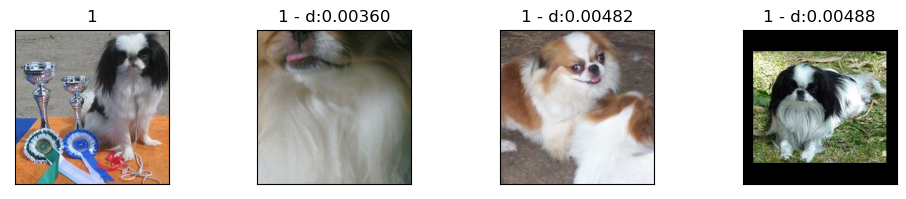

**Known Class**

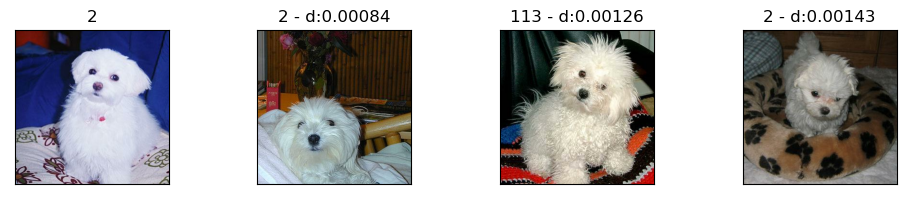

**Known Class**

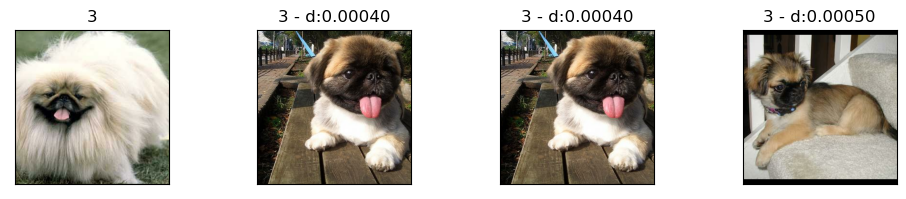

**Unknown Class**

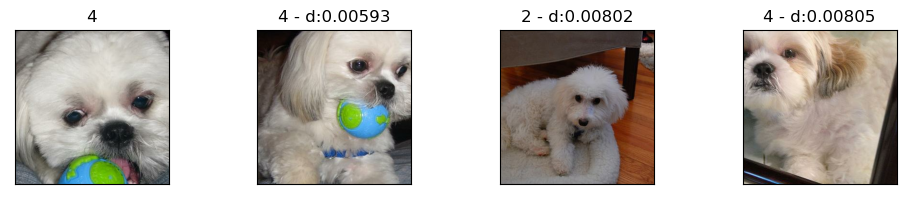

**Unknown Class**

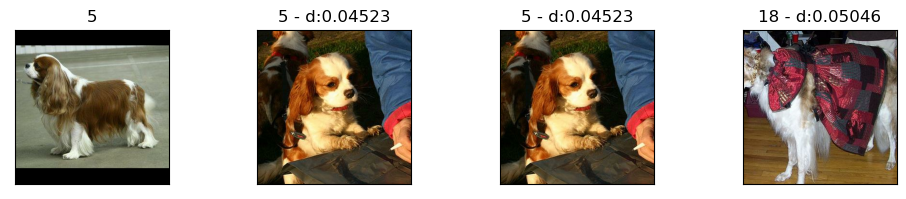

**Known Class**

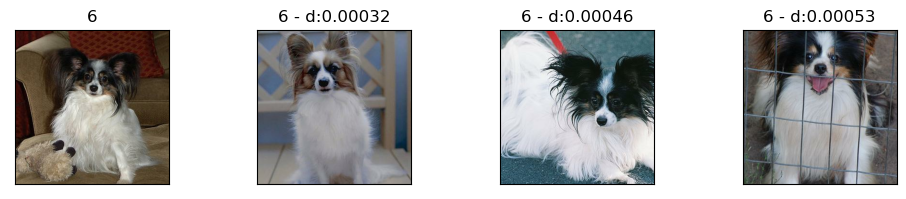

**Known Class**

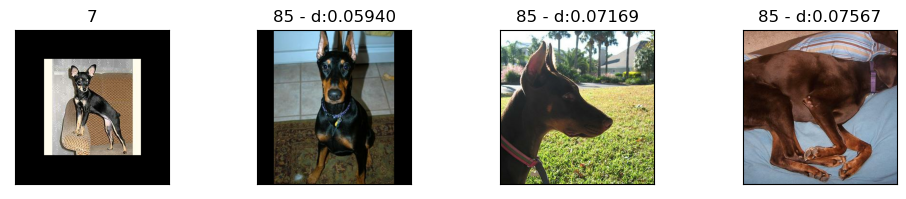

**Known Class**

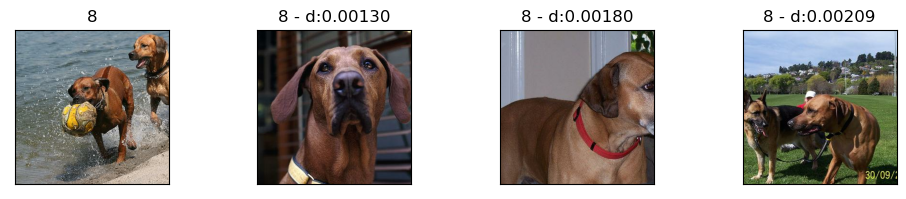

**Known Class**

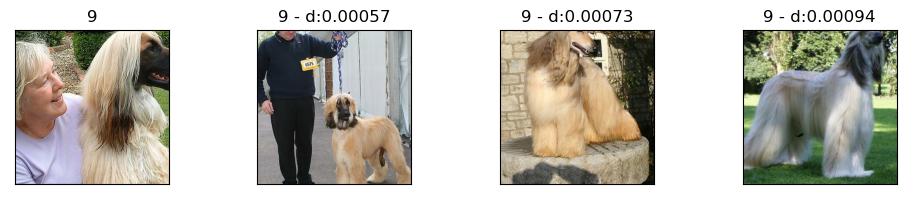

**Unknown Class**

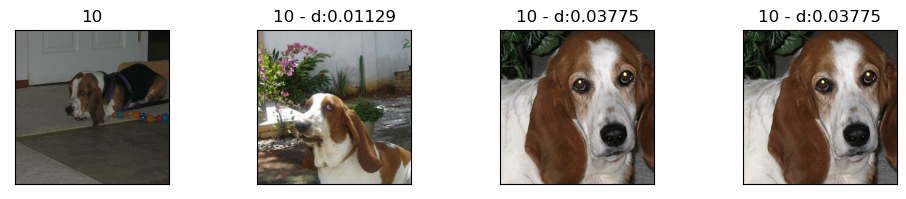

**Unknown Class**

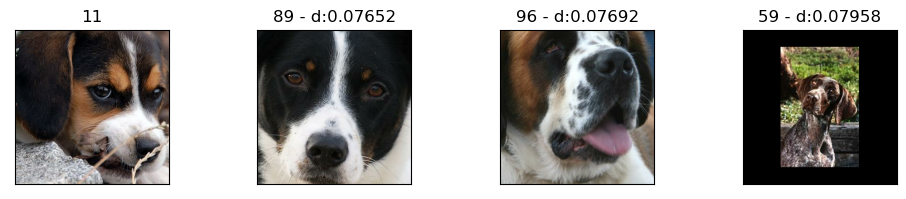

**Known Class**

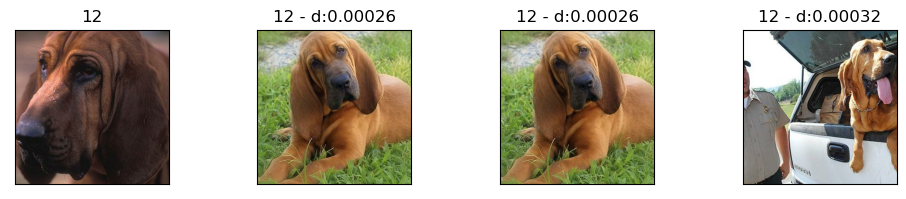

**Known Class**

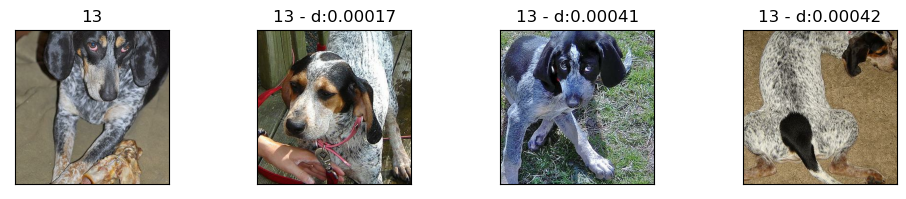

**Known Class**

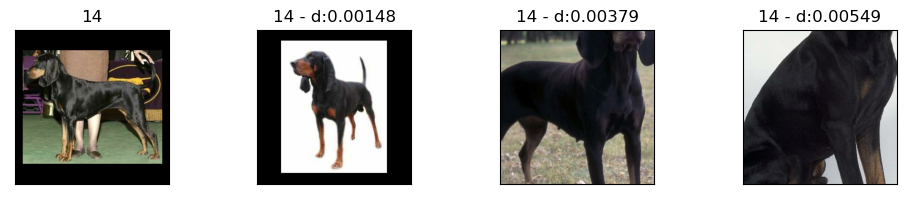

**Unknown Class**

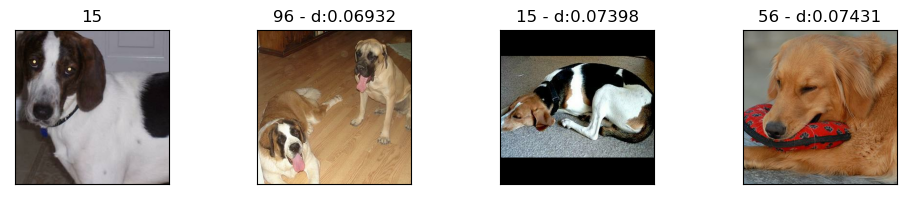

**Unknown Class**

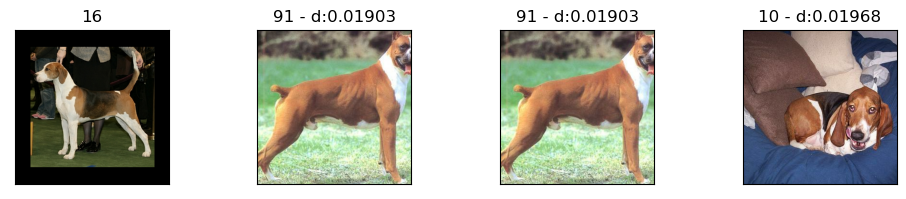

**Unknown Class**

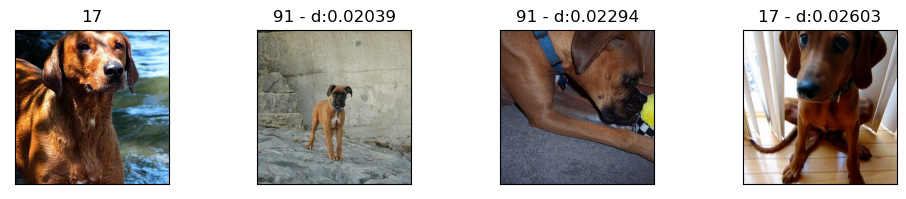

**Unknown Class**

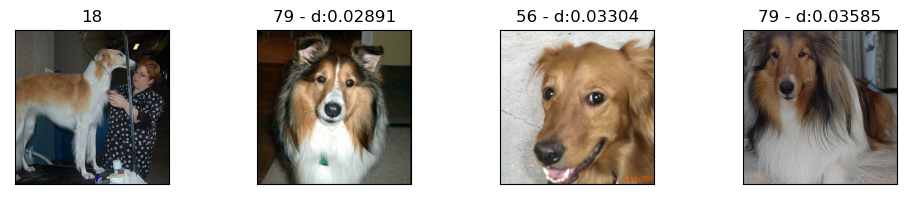

**Known Class**

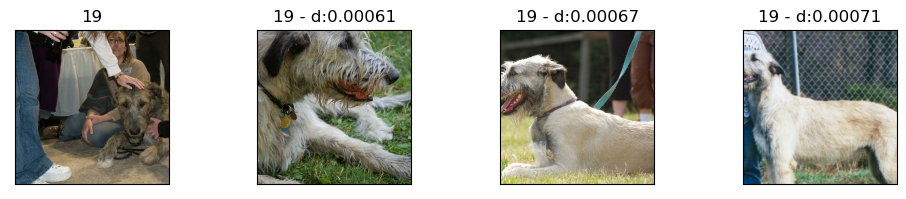

In [26]:
# re-run to test other examples
num_neighboors = 3
x_query, y_query = select_examples(
    x=x_test, 
    y=y_test, 
    class_list=range(20), # Test the first 20 classes.
    num_examples_per_class=1, # Query a single example from each class.
)

for idx in np.argsort(y_query):
    # query closest matches
    neighboors = model.single_lookup(x_query[idx], k=num_neighboors)
    # view results close by
    if y_query[idx] in classes:
        display(Markdown('**Known Class**'))
    else:
        display(Markdown('**Unknown Class**'))
    viz_neigbors_imgs(x_query[idx], y_query[idx], neighboors, class_mapping=labels, fig_size=(12, 2), cmap='Greys')

## Saving

In [27]:
# save the model and the index
# FIXME move after the calibration
save_path = 'models/dogs/' #@param {type:"string"}
model.save(save_path)

INFO:tensorflow:Assets written to: models/dogs/assets


INFO:tensorflow:Assets written to: models/dogs/assets


# matching


**FIXME: enable custom thresholds**


To be able to tell if an example match a given class, we first need to `calibrate()` the model to know what is the optimal cut point. We compute several cutpoints that correspond to different performance profile:
- **match** is the optimal cutpoint that represent the best balance between precision and recall
- **very likely** is the distance cutpoint that aim to ensure a 0.99 precision.

In [28]:
num_calibration_samples = 1000
calibration = model.calibrate(*select_examples(x_train, y_train, range(120), int(num_calibration_samples/NUM_CLASSES)), verbose=1)

filtering examples:   0%|          | 0/12000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/120 [00:00<?, ?it/s]


Performing NN search



Building NN list:   0%|          | 0/960 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4800 [00:00<?, ?it/s]

computing thresholds:   0%|          | 0/4800 [00:00<?, ?it/s]


 name       value    distance    accuracy    recall    f1_score
-------  -------  ----------  ----------  --------  ----------
optimal     0.17    0.131801   0.0916667  0.908333    0.166528


Let's look how the performance metrics evolve as the distance between the sample increase. We clearly see the F1 optimial cutpoint where the precision and recall intersect.

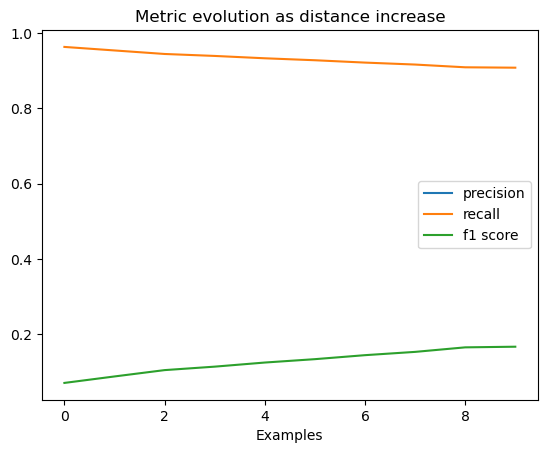

In [29]:
fig, ax = plt.subplots()
ax.plot(calibration['thresholds']['precision'], label='precision')
ax.plot(calibration['thresholds']['recall'], label='recall')
ax.plot(calibration['thresholds']['f1_score'], label='f1 score')
ax.legend()
ax.set_title("Metric evolution as distance increase")
ax.set_xlabel('Examples')
plt.show()

In [30]:
for k, v in calibration['thresholds'].items():
    print(f'{k:>9}: {v}')

    value: [0.07, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17]
 accuracy: [0.036458333333333336, 0.04583333333333333, 0.05520833333333333, 0.06041666666666667, 0.06666666666666667, 0.071875, 0.078125, 0.08333333333333333, 0.090625, 0.09166666666666666]
   recall: [0.9635416666666666, 0.9541666666666667, 0.9447916666666667, 0.9395833333333333, 0.9333333333333333, 0.928125, 0.921875, 0.9166666666666666, 0.909375, 0.9083333333333333]
 f1_score: [0.07025824652777778, 0.08746527777777778, 0.10432074652777777, 0.11353298611111111, 0.12444444444444444, 0.13341796874999998, 0.14404296875, 0.15277777777777776, 0.16482421875, 0.16652777777777777]
 distance: [6e-08, 1.2e-07, 3.6e-07, 0.00354129, 0.01512384, 0.01928091, 0.03500223, 0.05017227, 0.08028948, 0.13180065]
precision: []


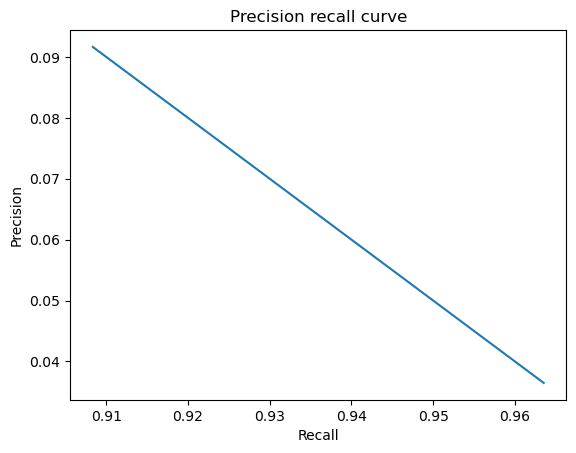

In [31]:
fig, ax = plt.subplots()
ax.plot(calibration['thresholds']['recall'], calibration['thresholds']['accuracy'])
ax.set_title("Precision recall curve")
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.show()

# Evaluation
We evaluate our model ability to accurately match new examples using our calibrated threshold by testing how many examples from the test sets are correctly matched. The example which have a distance above the cutoff are excluded and labeled as unknown.

The evaluation below reports 

In [32]:
metrics = model.evaluate_matching(tf.stack(x_test), y_test)

|-Computing embeddings


Evaluating cutpoints:   0%|          | 0/1 [00:00<?, ?it/s]


Performing NN search



Building NN list:   0%|          | 0/8580 [00:00<?, ?it/s]


 [Summary]

name       f1_score    accuracy    recall    distance
-------  ----------  ----------  --------  ----------
optimal   0.0833794   0.0435897   0.95641    0.131801


# match

Let's now match a 100 examples to see how you can use the `match()` function in practice. `match()` return you what class the example belong to based of the content of the index and allows to use your model to make prediction on an unbounded, added after training, classes!

Note: `match()` return -1 by default when the distance between the submited example and any point of the index is above the distance cutpoint.

In [33]:
num_matches = 10

matches = model.match(tf.stack(x_test[:num_matches]), cutpoint='optimal')
rows = []
for idx, match in enumerate(matches):
    rows.append([match, y_test[idx], match == y_test[idx]])
print(tabulate(rows, headers=['Predicted', 'True', 'correct']))

  Predicted    True    correct
-----------  ------  ---------
        108     108          1
         19      71          0
          0      11          0
         75      75          1
         77      77          1
          9       9          1
         50      50          1
         20      19          0
         41      41          1
        118     118          1


# Index information

Following `model.summary()` you can get information about the index configuration and its performance using `index_summary()`.

In [34]:
model.index_summary()

[Info]
------------------  --------
distance            cosine
index table         memory
matching algorithm  nmslib
evaluator           memory
index size          2400
calibrated          True
calibration_metric  f1_score
embedding_output
------------------  --------



[Performance]
-----------  --------------
num lookups  9571
min             3.64029e-05
max             9.47714e-05
avg             3.69866e-05
median          3.64029e-05
stddev          5.80759e-06
-----------  --------------


# Saving and reloading
Saving and reloading the model works as you would expected: 
- `model.save(path)`: save the model and the index on disk (`save_index=False`). By default the index is compressed - can be disabled by setting `compressed=False`
- `model = tf.keras.model.load_model(path)` reload the model. To reload the index you then need to call model.load_index(path)
- `model.save_index(path)` and `model.load_index(path)` allows to save/reload an index indenpendly of saving/loading a model if need to be


## Reloading

In [ ]:
# reload the model
reloaded_model = load_model(save_path)
# reload the index
reloaded_model.load_index(save_path)

In [36]:
#check the index is back
reloaded_model.index_summary()

[Info]
------------------  --------
distance            cosine
index table         memory
matching algorithm  nmslib
evaluator           memory
index size          2400
calibrated          False
calibration_metric  f1_score
embedding_output
------------------  --------



[Performance]
-----------  -
num lookups  0
min          0
max          0
avg          0
median       0
stddev       0
-----------  -


## Query reloaded model
Querying the reloaded model with its reload index works as expected

filtering examples:   0%|          | 0/8580 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

**Unknown Class**

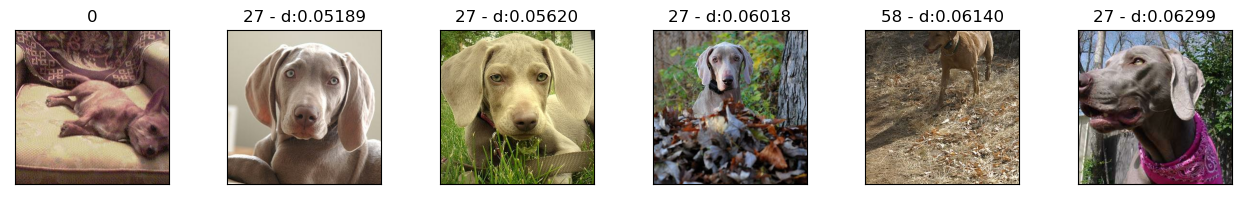

**Unknown Class**

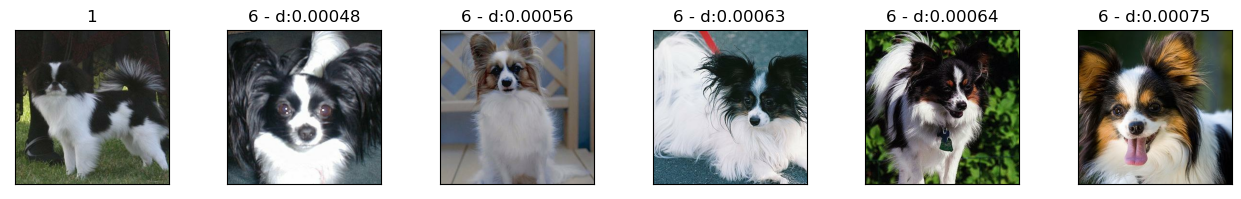

**Known Class**

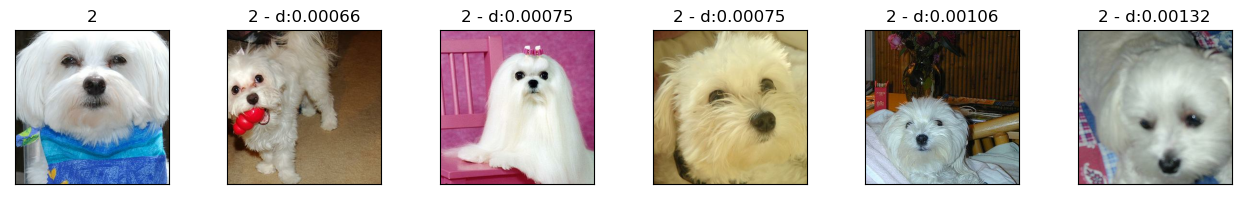

**Known Class**

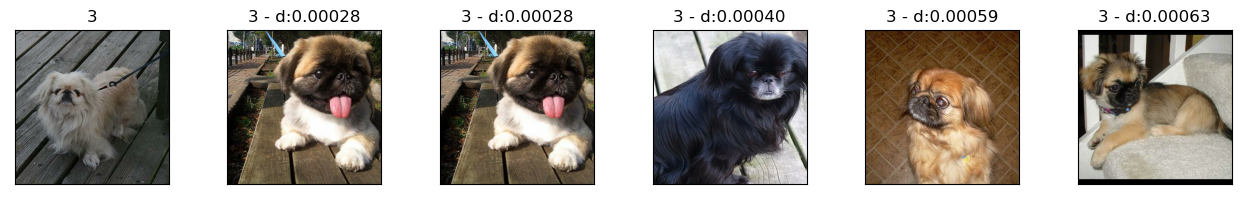

**Unknown Class**

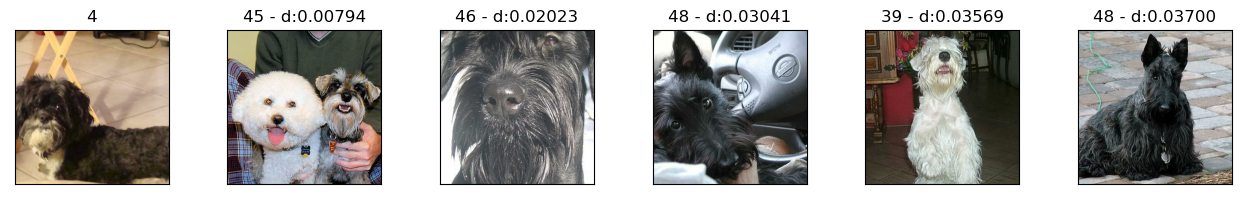

**Unknown Class**

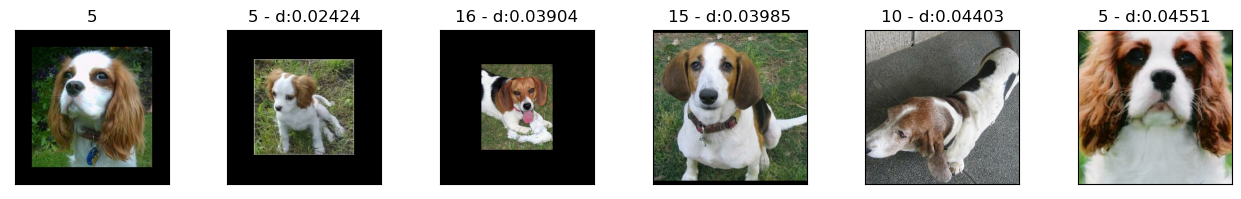

**Known Class**

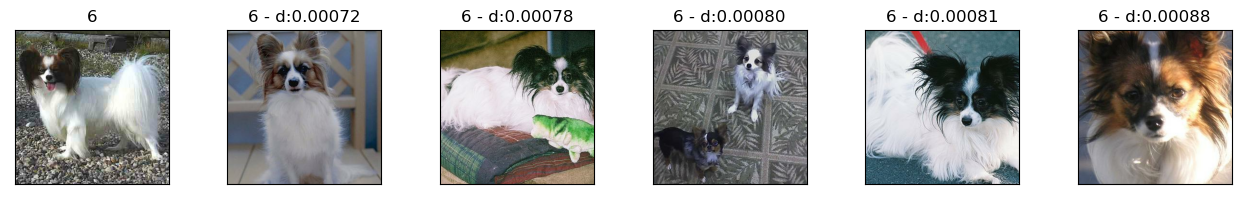

**Known Class**

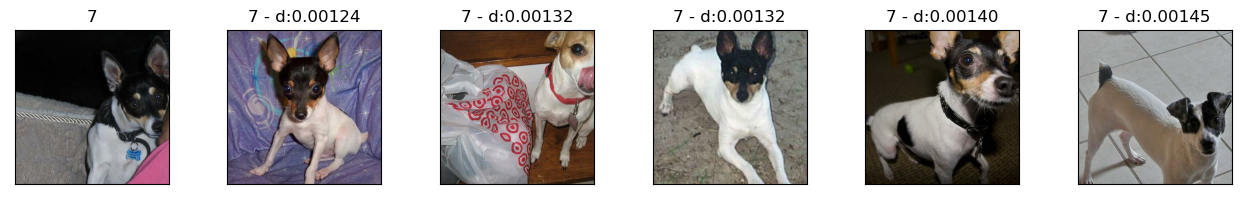

**Known Class**

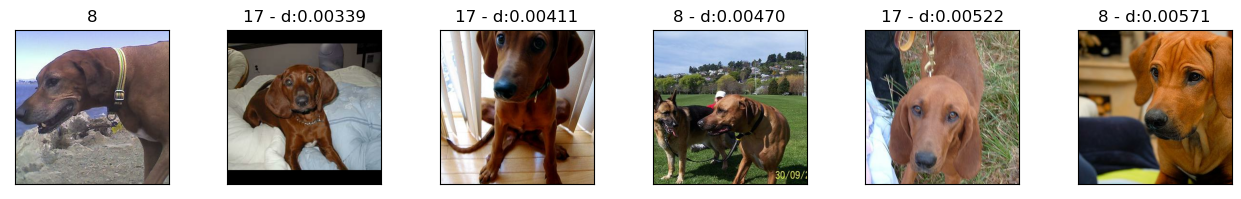

**Known Class**

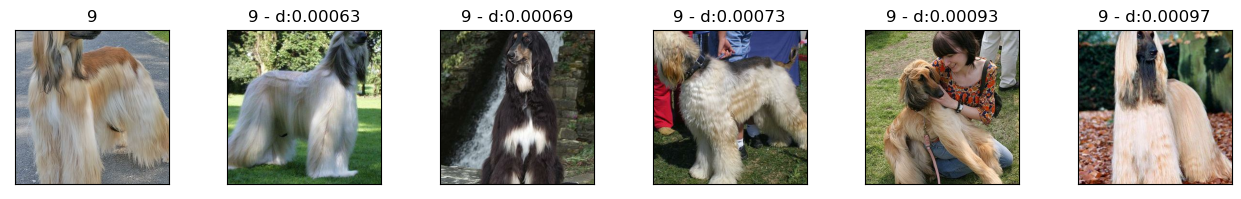

In [38]:
# re-run to test other examples
num_neighboors = 5
x_query, y_query = select_examples(
    x=x_test, 
    y=y_test, 
    class_list=range(10), # Test the first 20 classes.
    num_examples_per_class=1, # Query a single example from each class.
)

for idx in np.argsort(y_query):
    # query closest matches
    neighboors = model.single_lookup(x_query[idx], k=num_neighboors)
    # view results close by
    if y_query[idx] in classes:
        display(Markdown('**Known Class**'))
    else:
        display(Markdown('**Unknown Class**'))
    viz_neigbors_imgs(x_query[idx], y_query[idx], neighboors, class_mapping=labels, fig_size=(16, 2), cmap='Greys')